# `rioxarray`

`rioxarray`:

- is a Python extension for `xarray` to manipulate `xarray.DataArray`s as rasters
- means *raster input/ouput + xarray*

## Data
Raster files from the US National Agriculture Imagery Program (NAIP)

- high-resolution aerial images from 2020 with four spectral bands: Red, Green, Blue and Near-infrared (NIR)
- data is pre-processed into two rasters (RGB and NIR)

## Import .tif

In [39]:
import os # to work with file paths
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
import rioxarray as rioxr

import geopandas as gpd
from shapely.geometry import Polygon

There are multiple ways of opening a .itf file using `xarray` or `rioxarray`.

Use `rioxarray.open_rasterio()` function to open the '.tif' file:

In [2]:
# load NIR tif file
#os.getcwd() = get current working directory

# create file path
nir_fp = os.path.join(os.getcwd(),'data','nir.tif')
nir = rioxr.open_rasterio(nir_fp)
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)>
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## `xr.DataArray` exploration

Let's verify we loaded an `xarray.DataArray`

In [3]:
type(nir)

xarray.core.dataarray.DataArray

In [4]:
# access some attributes
print('shape:', nir.shape)
print('data type:', nir.dtype)

shape: (1, 3208, 2419)
data type: uint8


In [5]:
# check values of array at the corners
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

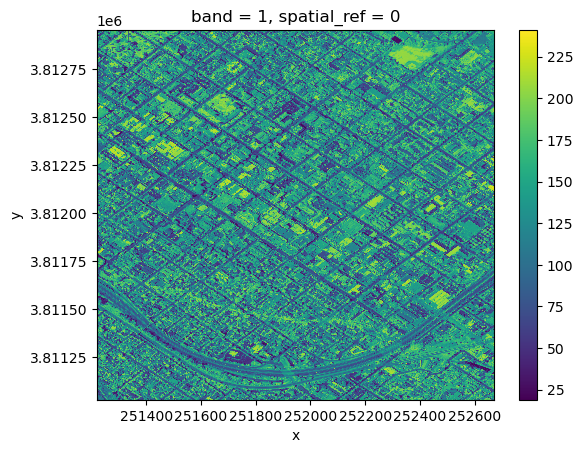

In [6]:
# exploratory plot
nir.plot()

## `rio` accessor

An **accessor** in Python let's us access a different set of properties from an object. 

Use the `.rio` accessor for `xarray.DataArray` to access its raster properties.

**Example**

In [7]:
print('# bands: ', nir.rio.count)
print('height: ', nir.rio.height)
print('width: ', nir.rio.width)
print('resolution: ', nir.rio.resolution())
print('no data values:', nir.rio.nodata, '\n')

print('spatial bounding box:')
print(nir.rio.bounds(),'\n')

print('CRS:', nir.rio.crs)

# bands:  1
height:  3208
width:  2419
resolution:  (0.6000000000000072, -0.600000000000058)
no data values: None 

spatial bounding box:
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

CRS: EPSG:26911


In [8]:
nir.rio.crs.is_projected

True

## Multi-band raster

In [9]:
# open RGB raster
rgb_fp = os.path.join(os.getcwd(), 'data', 'rgb.tif')
rgb = rioxr.open_rasterio(rgb_fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)>
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [10]:
# check some number bands and shape
print('rgb shape:', rgb.shape)
print('rgb # bands:', rgb.rio.count)

rgb shape: (3, 3208, 2419)
rgb # bands: 3


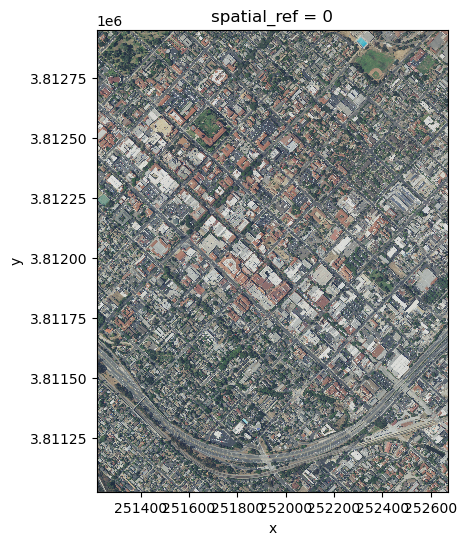

In [11]:
# parameters for plotting this raster
size = 6 # height of figure in inches
aspect = rgb.rio.width / rgb.rio.height # ratio width/height

# plot three bands as RGB image
rgb.plot.imshow( size=size, aspect=aspect)

## Box for clipping

Our area of interest (aoi) is a smaller region with only a few blocks around the NCEAS building

In [12]:
# list of vertices of our aoi box
points = [[-119.70712880941859,34.42624118576657],
             [-119.70712880941859,34.42069057473634],
             [-119.69742455430239,34.42069057473634],
             [-119.69742455430239,34.42624118576657],
             [-119.70712880941859,34.42624118576657]]


<AxesSubplot:>

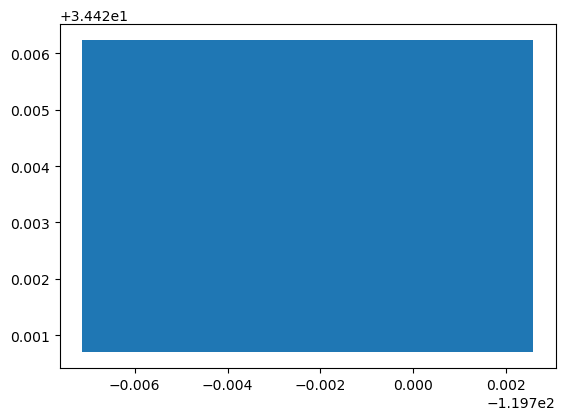

In [13]:
points2 = [[-119.70712880941859,34.42624118576657],
             [-119.70712880941859,34.42069057473634],
             [-119.69742455430239,34.42069057473634],
             [-119.69742455430239,34.42624118576657]]

# create a geodatafram with aoi
gpd.GeoDataFrame(geometry = [Polygon(points2)],
                       crs = 'epsg:4326').plot()

In [14]:
# create a geodatafram with aoi
aoi = gpd.GeoDataFrame(geometry = [Polygon(points)],
                       crs = 'epsg:4326' 
                      )
aoi

,geometry
0,"POLYGON ((-119.70713 34.42624, -119.70713 34.4..."


<AxesSubplot:>

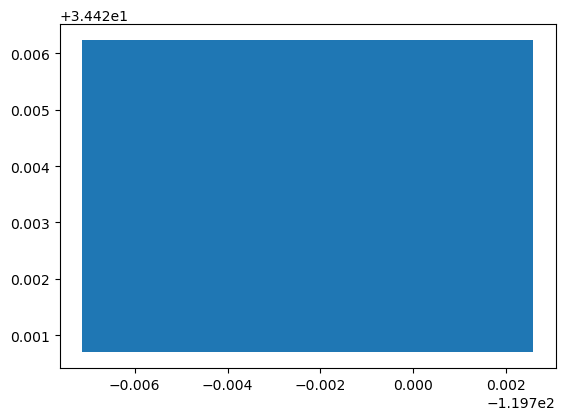

In [15]:
aoi.plot()

## Clip raster

Remember: **it two geospatial sets will interact they need to be in the same CRS**

Check:

In [16]:
print('aoi CRS:', aoi.crs)
print('nir CRS: ', nir.rio.crs)
print('rgb CRS:', rgb.rio.crs)

aoi CRS: epsg:4326
nir CRS:  EPSG:26911
rgb CRS: EPSG:26911


In [17]:
# reproject aoi to rgb crs
aoi = aoi.to_crs(rgb.rio.crs)
print('matched crs?', aoi.crs == rgb.rio.crs)
aoi.crs

matched crs? True


<Bound CRS: PROJCS["NAD83 / UTM zone 11N",GEOGCS["NAD83",DATUM ...>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from NAD83 to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Source CRS: NAD83 / UTM zone 11N

<AxesSubplot:title={'center':'spatial_ref = 0'}, xlabel='x', ylabel='y'>

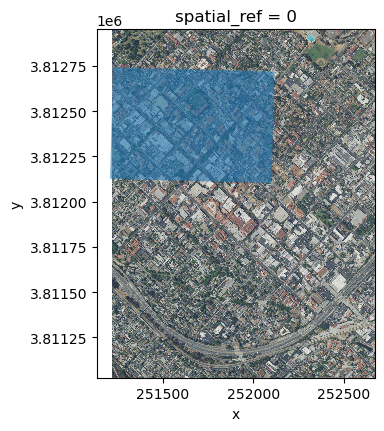

In [18]:
# plot aoi outline and RGB raster togehter
fig, ax = plt.subplots()
fig.set_size_inches((size, size*aspect)) # cannot use ax and size, aspect together 
rgb.plot.imshow(ax=ax)
aoi.plot(ax=ax, alpha=0.6)

To clip the raster using the aoi poluygon we use the `.rio.clip_box()` method:

In [19]:
# clip rasters to aoi
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = nir.rio.clip_box(*aoi.total_bounds)

In [20]:
print('original shape:', rgb.shape)
print('reduced shape:', rgb_small.shape)

original shape: (3, 3208, 2419)
reduced shape: (3, 1067, 1497)


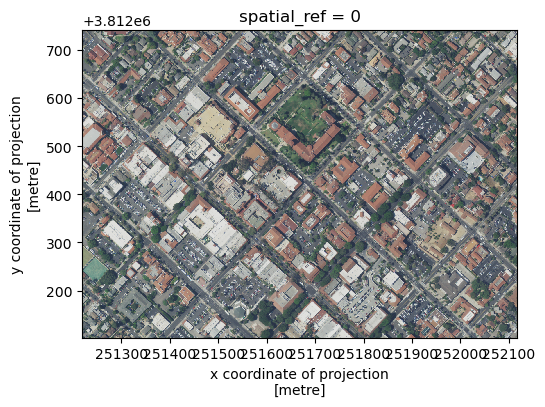

In [21]:
# plot it with correct ratio
size = 4 # height in inches
aspect = rgb_small.rio.width / rgb_small.rio.height
rgb_small.plot.imshow(size=size, aspect=aspect)

## Compute NDVI

NDVI = Normalized Difference Vegetation Index.
We want to compute it over our aoi. 

NDVI: 
- index used to check if an area has live green vegetation
- calculated using only the red and NIR bands
- formula: $$NDVI = (NIR - Red)/(NIR+Red)$$
- results range from -1 to 1
- plants: always poisitive values between 0.2 and 1

First, select the red band:

In [22]:
red = rgb_small.sel(band=1)
red

<xarray.DataArray (y: 1067, x: 1497)>
[1597299 values with dtype=uint8]
Coordinates:
    band         int64 1
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.521e+05 2.521e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

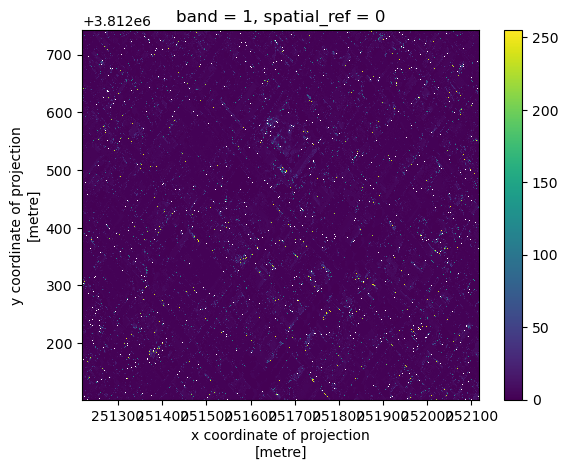

In [26]:
ndvi = (nir_small - red)/(nir_small + red)
ndvi.plot()

## What is happening?

Both NIR and red have `uint8` dtype. 

`uint8` (8-bit unsigned integer). 
very small data type that only holds integers from 0 up to 255
Calculations with `uint8` don't return what we are used to when working with integers:

In [27]:
np.uint8(150) + np.uint8(150)

/tmp/ipykernel_1501121/1890984988.py:1: RuntimeWarning: overflow encountered in ubyte_scalars
  np.uint8(150) + np.uint8(150)


44

In NDVI formula we add NIR + Red. If both NIR and Red are very close to 255, when we add them, the calculation overflows the `uint8` dtype

Notice: when we performed the NDVI calculation, we did not get any warning. 

This could be called an example of *failing siltenly* 

**Important: check our results!!**

Solution: update dtype of rasters to `int16` which will be big enough to perform the calculation

In [28]:
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')
print('RED: original dtype', rgb_small.dtype, '.... new dtype:', red16.dtype)
print('RED: original dtype', nir_small.dtype, '.... new dtype:', nir16.dtype)

RED: original dtype uint8 .... new dtype: int16
RED: original dtype uint8 .... new dtype: int16


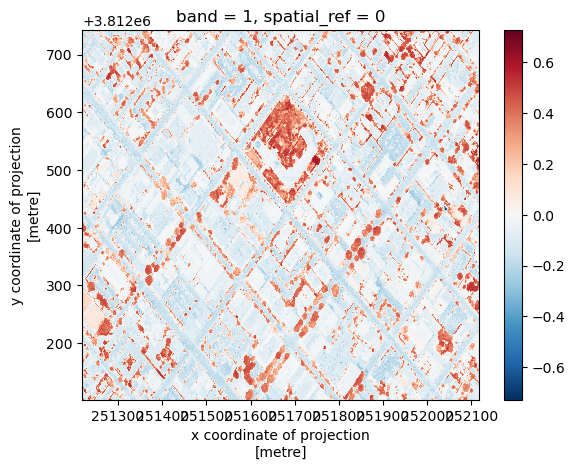

In [30]:
# perform raster calculations using the same arithmetic as np.arrays
ndvi = (nir16 - red16)/(nir16 + red16)
ndvi.plot()

(array([9.00000e+00, 1.30000e+01, 6.00000e+00, 5.00000e+00, 2.00000e+00,
        4.00000e+00, 7.00000e+00, 3.00000e+00, 6.00000e+00, 7.00000e+00,
        9.00000e+00, 2.00000e+01, 3.10000e+01, 4.50000e+01, 1.25000e+02,
        3.85000e+02, 1.28900e+03, 4.11100e+03, 1.19130e+04, 3.73090e+04,
        8.89430e+04, 1.40203e+05, 1.45122e+05, 1.91560e+05, 1.76602e+05,
        1.95561e+05, 1.71793e+05, 4.51550e+04, 2.98630e+04, 2.66420e+04,
        2.14450e+04, 1.95400e+04, 1.88600e+04, 1.83660e+04, 1.91960e+04,
        2.08050e+04, 2.19640e+04, 2.36240e+04, 2.49200e+04, 2.59490e+04,
        2.63630e+04, 2.59240e+04, 2.32570e+04, 1.84930e+04, 1.20870e+04,
        6.38900e+03, 2.26900e+03, 6.88000e+02, 3.55000e+02, 6.20000e+01]),
 array([-0.72677596, -0.69968983, -0.6726037 , -0.64551758, -0.61843145,
        -0.59134532, -0.5642592 , -0.53717307, -0.51008694, -0.48300082,
        -0.45591469, -0.42882857, -0.40174244, -0.37465631, -0.34757019,
        -0.32048406, -0.29339793, -0.26631181, -0

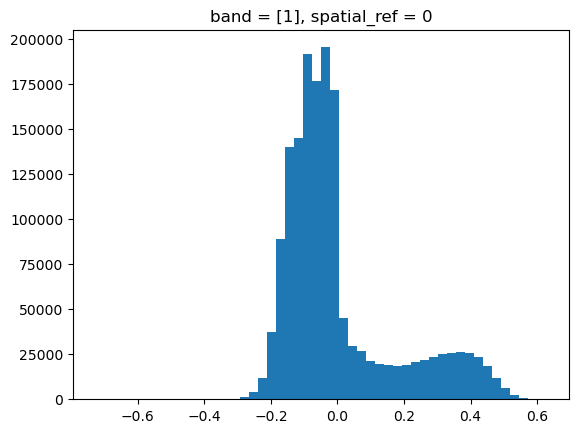

In [32]:
# create a histogram of the ndvi values
ndvi.plot.hist(bins=50)

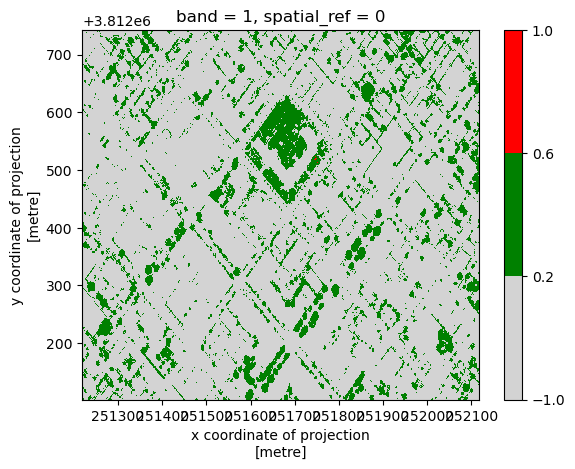

In [38]:
# -1 < NDVI <0.2 : no vegetation
# 0.2 <= NDVI < 0.6 for sparse vegetation
# 0.6 < NDVI < 1 for dense vegetation

class_bins = (-1, 0.2, 0.6, 1)
colors = ('lightgray', 'green', 'red')
ndvi.plot(levels=class_bins, colors=colors)

In [40]:
ndvi_classes = xr.apply_ufunc(
    np.digitize,
    ndvi,
    class_bins
)
ndvi_classes

<xarray.DataArray (band: 1, y: 1067, x: 1497)>
array([[[1, 1, 1, ..., 2, 2, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 2, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.521e+05 2.521e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 0

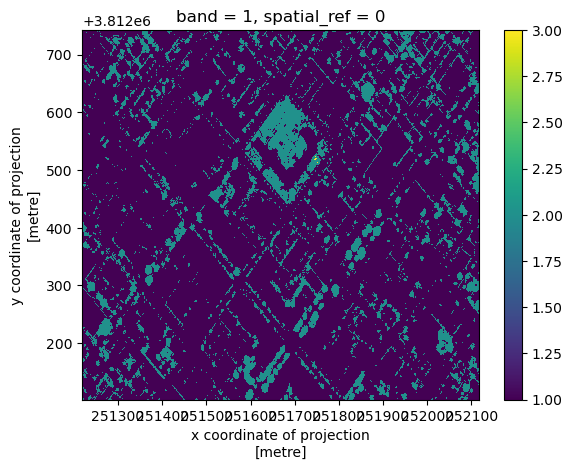

In [41]:
ndvi_classes.plot()